# **Service Discovery 위한 CoreDNS 사용하기**


# CoreDNS 개요

Service를 생성하면 대응하는 DNS entry가 생성.

### 형식

`{Service 명}.{Namespace 명}.svc.cluster.local`

### 예시

1) Pod 조회
```
$ kubectl get pod
NAME                                      READY   STATUS    RESTARTS   AGE
pod/http-go-5c6f458dc9-wtpdq              1/1     Running   0          7m31s
```

2) Pod 내부 접속
```
$ kubectl exec -it http-go-5c6f458dc9-wtpdq -- bash
```

3) DNS를 활용한 Service 검색 1
```
root@http-go-5c6f458dc9-wtpdq:/usr/src/app# curl http-go-svc 
Welcome! http-go-5c6f458dc9-wtpdq
```

4) DNS를 활용한 Service 검색 2 - svc.cluster.local 생략 가능
```
root@http-go-5c6f458dc9-wtpdq:/usr/src/app# curl http-go-svc.default
Welcome! http-go-5c6f458dc9-wtpdq
```

5) DNS를 활용한 Service 검색 3 - default Namespace 생략 가능
```
root@http-go-5c6f458dc9-wtpdq:/usr/src/app# curl http-go-svc
Welcome! http-go-5c6f458dc9-wtpdq
```

# CoreDNS 기능

* 내부에서 DNS 서버 역할을 하는 Pod가 존재
* 각 미들웨어를 통해 로깅, 캐싱, Kuberentes를 질의하는 등의 기능을 가짐




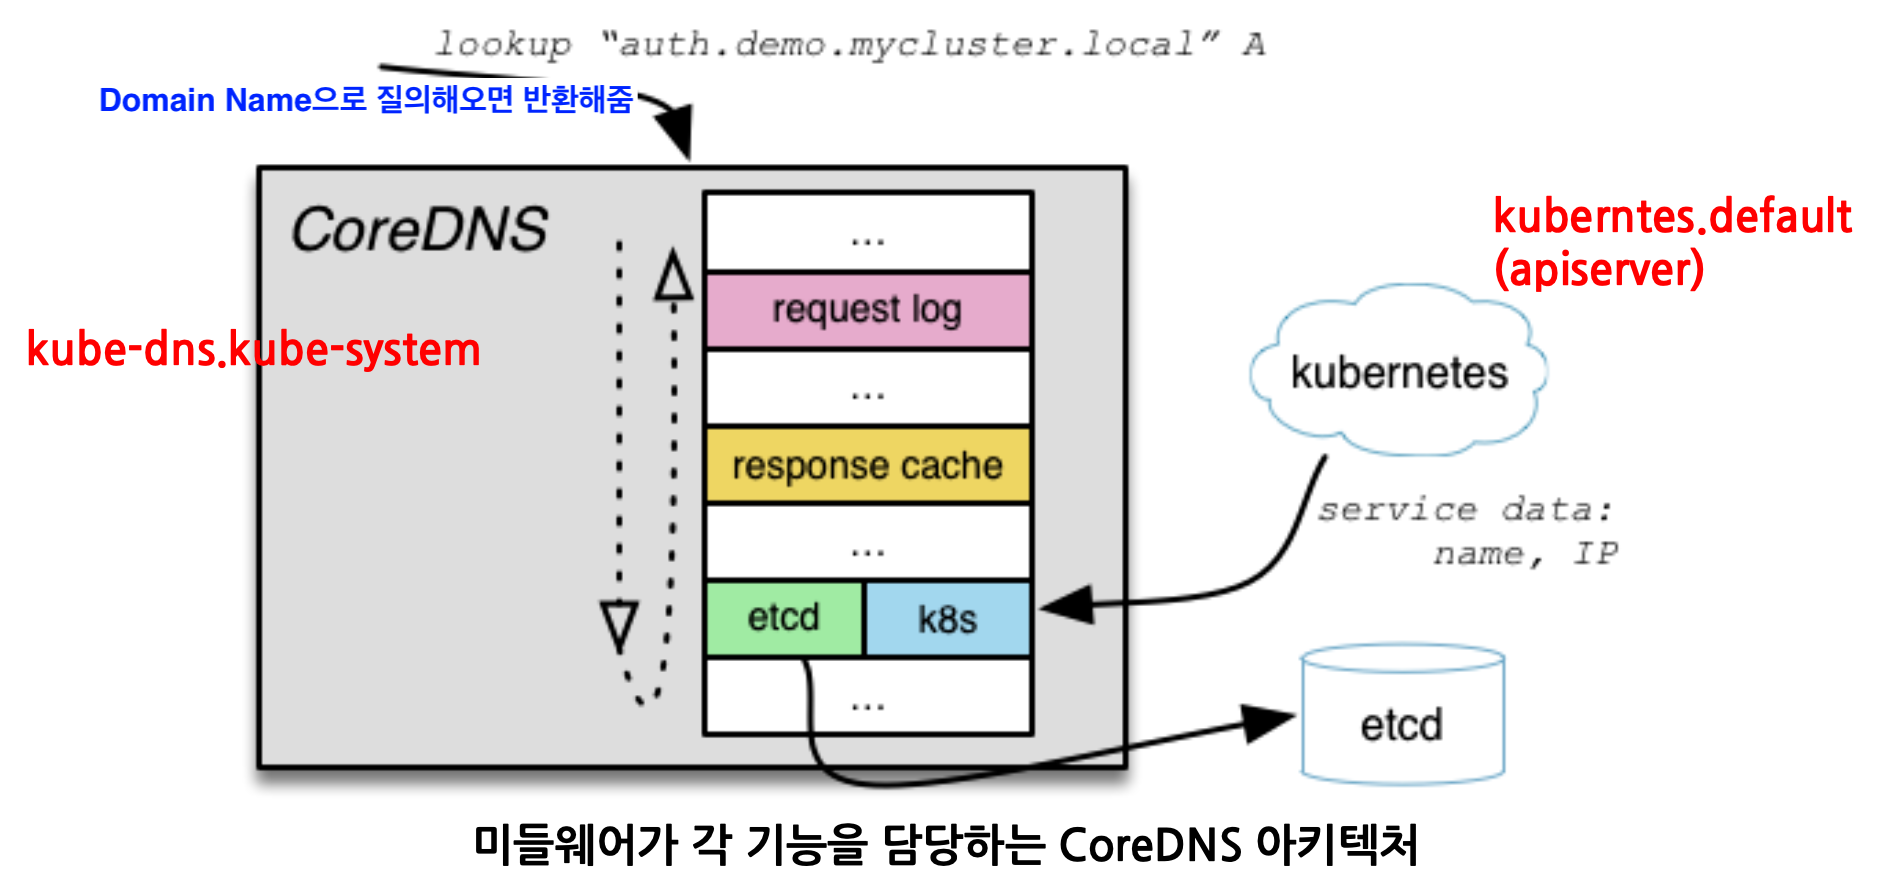


* 해당 DNS에는 `configmap` 저장소를 사용해 설정 파일을 컨트롤
```
$ kubectl get configmap coredns -n kube-system -o yaml
apiVersion: v1
data:
  Corefile: |       # NS 지정
    .:53 {
        errors
        health {
           lameduck 5s
        }
        ready
        kubernetes cluster.local in-addr.arpa ip6.arpa {
           pods insecure
           fallthrough in-addr.arpa ip6.arpa
           ttl 30
        }
        prometheus :9153
        forward . /etc/resolv.conf {
           max_concurrent 1000
        }
        cache 30
        loop
        reload
        loadbalance
    }
(중략)
```

### Pod에서도 Subdomain을 사용하면 DNS 서비스 사용 가능

* 원래 CoreDNS는 Service까지만 조회 가능했으나, Pod에서도 Subdomain을 사용하면 DNS 서비스 사용 가능
* yaml 파일의 hostname은 Pod의 `metadata.name`의 value를 따름(필요한 경우 hostname을 따로 선택 가능)
* `subdomain` object는 서브 도메인을 지정하는데 사용 -> 서브 도메인을 지정하면 FQDN 사용 가능
  * FQDN 형식: {hostname}.{subdomain}.{namespace}.svc.cluster-domain.example
  * FQDN 예시: busybox-1.default-subdomain.default.svc.cluster-domain.example


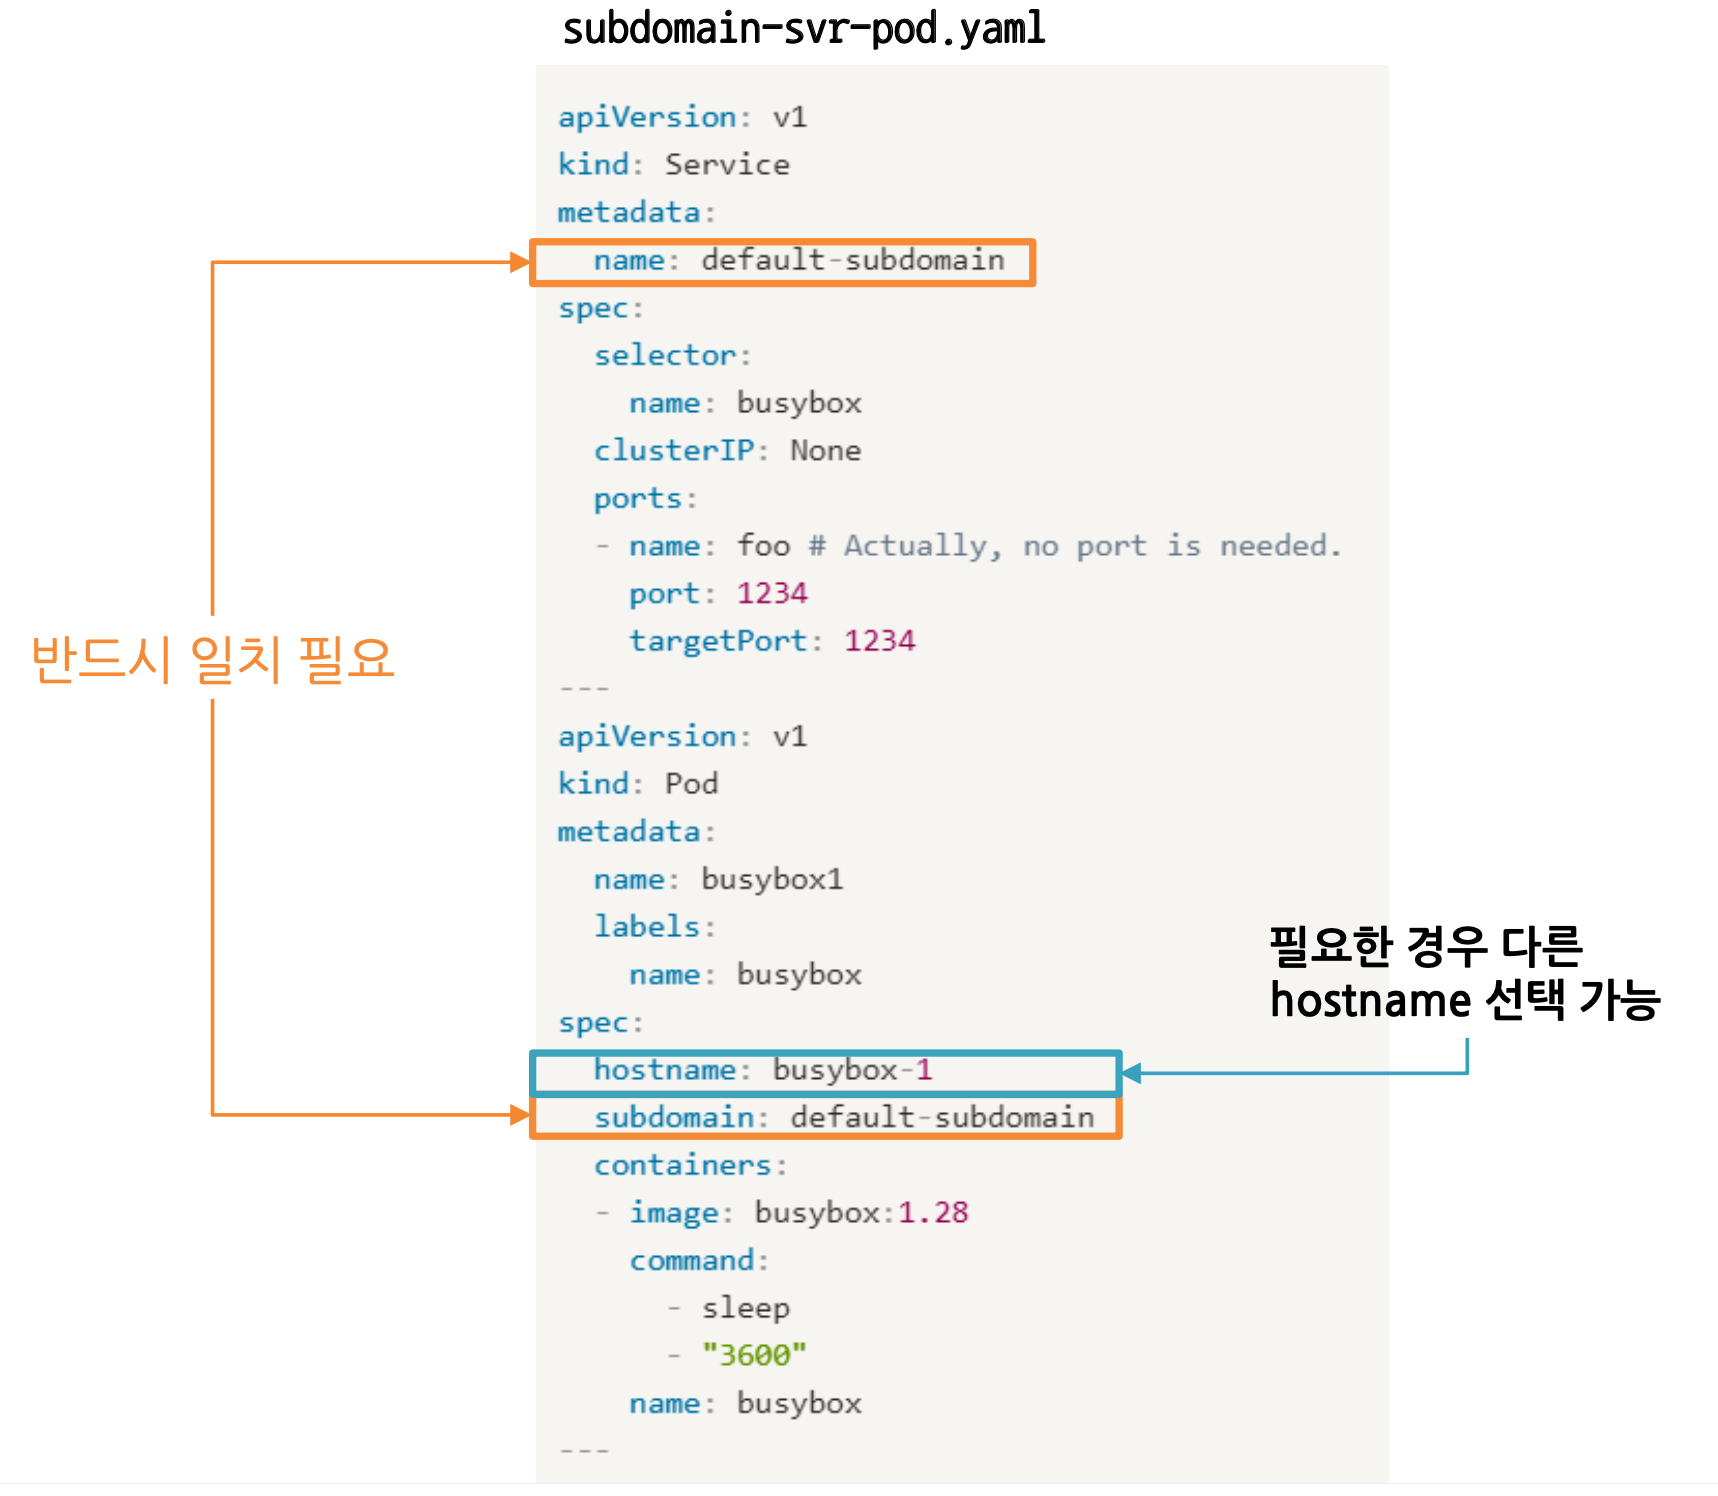